#  Optimal FingerPrint



Code pour l'implémentation de la méthode de l'Optimal Fingerprint par Sara Grissia, Chadha Hassine, Eliott Le Dauphin, Francis Jégou et Mohamed Ghali Es Sadel

#Dependances et path vers le drive

##Dépendances

Les librairies à installer sont:
- netCDF4 pour notamment ouvrir les fichiers dans lesquelles se trouvent nos données
- cftime pour pouvoir convertir les dates dans le format souhaité
- cartopy pour vouvoir faire des cartes

In [ ]:
!pip install netCDF4
!pip install cftime
!pip install cartopy

In [ ]:
import xarray as xr
import numpy as np
import os
import cftime
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import gc
from sklearn.decomposition import PCA
import pandas as pd
import scipy.stats as stats
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Paths

In [ ]:
path='drive/MyDrive/projet/data'
path_obs = 'drive/MyDrive/projet/data_observation_ERA5'
file_name = "ERA5_1940-2024_Monthly_TAS.nc"

# Détermier $\beta$

Dans cette partie on va calculer $\beta$ et ensuite le représenter sur une carte

##Calcul de $\beta$

Dans cette sous partie, on va va calculer $\beta = X^T C_N^{-1}$

Etape 1: extraire et premier traitement des données

Pour cette étape, on extrait les données puis on réduit la granularité (la dimension) et on traite les données mois par mois car on a beaucoup de données et cela prend pas mal de mémoire et veux faire rentrer ces données dans la RAM mais beaucoup de données engendre aussi plus d'incertitude dans le calcul de la matrice de covariance $C_N$.

Parler des anomalies ????????????

In [ ]:
def reduce_granularity(ds, target_points):
    lat_points = ds.sizes['lat']
    lon_points = ds.sizes['lon']
    total_points = lat_points * lon_points
    factor = int(np.sqrt(total_points / target_points))
    ds_reduced = ds.coarsen(lat=factor, lon=factor, boundary='trim').mean()
    return ds_reduced

def traitement_data(ds, start_past, end_past, start_present, end_present, n_pt):
    data_past = ds.sel(time=slice(start_past, end_past))
    data_past = reduce_granularity(data_past, n_pt)
    seasonalities = data_past.groupby('time.month').mean('time')
    anomalies_past = data_past.groupby('time.month') - seasonalities
    anomalies_past_yearly = anomalies_past.resample(time='1YE').mean()

    data_present = ds.sel(time=slice(start_present, end_present))
    data_present = reduce_granularity(data_present, n_pt)
    anomalies_present = data_present.groupby('time.month') - seasonalities
    anomalies_present_yearly = anomalies_present.resample(time='1YE').mean()

    return anomalies_past_yearly.tas.data, anomalies_present_yearly.tas.data

def extraction_data(path, start_past, end_past, start_present, end_present, nb_f, n_pt): #nb_f nombre de fichier sur lesquels on veut extraire les données, si nb_f faire sur tous les fichiers
    if(nb_f == 0):
        n = 50
    else:
        n = nb_f
    full_data_past = []
    full_data_present = []
    for file_name in os.listdir(path)[:n]:
        full_path = path + '/' + file_name
        xarray = xr.open_dataset(full_path)
        past, present = traitement_data(xarray, start_past, end_past, start_present, end_present, n_pt)
        full_data_past.append(past)
        full_data_present.append(present)

    full_data_past = np.array(full_data_past)
    full_data_present = np.array(full_data_present)
    return full_data_past, full_data_present

Etape 2: redimensionner les anomalies

On va redimensionner la matrice d'anomalies pour pouvoir faire les opérations sur les matrice comme on le souhaite.

In [ ]:
def reshape_anomalies(anomaly_data):
    n_simulations, time, lat, lon = anomaly_data.shape
    return anomaly_data.reshape((n_simulations * time, lat * lon))

Etape 3: calcul du signal $X$ et de la matrice de covariance $C_N$

In [ ]:
def compute_covariance_and_signal(full_data_past, full_data_present):
    C_N = np.cov(full_data_past, rowvar=False)
    response_past = np.mean(full_data_past, axis=0)
    response_present = np.mean(full_data_present, axis=0)
    X = response_present - response_past
    return C_N, X

Etape 4: Calcul de $\beta$

Ici on va simplement appliquer la formule vu précedemment pour calculer $\beta$

In [ ]:
def calculate_beta(C_N, X):
    return np.linalg.solve(C_N, X)

Etape 5: Tout mettre ensemble

On va maintenant combiner les quatres premières étapes pour calculer $\beta$. On va aussi ajouter la décomposition en composantes principales (PCA) qui va nous permettre à nouveau de réduire le nombre de données que l'on utilise tout en conservant le plus d'imformations possibles pour minimiser les erreurs dans le caclul de $\beta$. On va par la suite déterminer le nombre optimal de composantes principales pour avoir le test le plus précis.

In [ ]:
def beta_calculation(path, start_past, end_past, start_present, end_present, n_comp, n_pt, n_f):
    full_data_past, full_data_present = extraction_data(path, start_past, end_past, start_present, end_present, n_f, n_pt)
    past_reshaped = reshape_anomalies(full_data_past)
    present_reshaped = reshape_anomalies(full_data_present)
    pca = PCA(n_components=n_comp) # on choisit nombre de composantes pour la PCA
    past_pca = pca.fit_transform(past_reshaped) # Fit transforme data_past
    present_pca = pca.transform(present_reshaped) # Tranforme les data_present
    C_N, X = compute_covariance_and_signal(past_pca, present_pca)
    beta = calculate_beta(C_N, X)
    return C_N, X, beta,full_data_past, full_data_present

On peut donc calculer $\beta$

In [ ]:
start_past = '1880-01-16'
end_past = '1950-01-16'

start_present = '1950-01-16'
end_present = '2022-12-16'

nb_composents = 30 # choix arbitraire
nb_pts = 1000
nb_fichiers = 50 # pour tous les fichiers

C_N, X, beta, past, present = beta_calculation(path, start_past, end_past, start_present, end_present, nb_composents, nb_pts, nb_fichiers)
beta

# cela peut prendre plusieurs minutes

array([ 0.20723087,  0.00854965,  0.01792834,  0.18143281, -0.0378883 ,
        0.10633791,  0.13006778, -0.21946687, -0.17279231,  0.23796335,
        0.07549719, -0.03939667, -0.26266592,  0.05738356,  0.28735694,
        0.00161465, -0.26893166,  0.57641679, -0.24750413, -0.14235641,
       -0.0968354 ,  0.48195197, -0.05552295, -0.26274775, -0.04053028,
        0.22551938, -0.18441168, -0.02978605,  0.04403424, -0.60434268])

##Plot de $\beta$

Dans cette partie on charcher à représenter $\beta$ ainsi que le signa $X$ sur une carte pour pouvoir voir plus concrètement à quoi ils ressemblent

Ici on a la fonction qui va nous permettre de faire nos différentes cartes

In [ ]:
def plot_map(beta_map, latitudes, longitudes, title='Map de beta', var_name='beta'):
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    mesh = ax.pcolormesh(longitudes, latitudes, beta_map, transform=ccrs.PlateCarree(), cmap='coolwarm')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    cbar = plt.colorbar(mesh, orientation='vertical', pad=0.05)
    cbar.set_label('Valeurs de ' + var_name)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlabel_style = {'size': 12, 'color': 'blue'}
    gl.ylabel_style = {'size': 12, 'color': 'blue'}
    plt.title(title)
    plt.show()

Maintenant il faut avoir les différentes données qui vont être nécessaire pour nos cartes:
- $\beta$
- latitude
-longitude


Comme nos fonctions précédentes ne nous permettent pas d'avoir la latitude et la longitude en caclculant beta, on va réimplémenter l'algorithme tout en réutilisant certaines des fonctions.

In [ ]:
full_data_past = []
full_data_present = []

for file_name in os.listdir(path)[:50]:
  full_path = path + '/' + file_name
  xarray = xr.open_dataset(full_path)

  data_past = xarray.sel(time=slice(start_past, end_past))
  data_past = reduce_granularity(data_past, 1000)
  seasonalities = data_past.groupby('time.month').mean('time')
  anomalies_past = data_past.groupby('time.month') - seasonalities
  anomalies_past_yearly = anomalies_past.resample(time='1YE').mean()
  full_data_past.append(anomalies_past_yearly.tas.data)

  data_present = xarray.sel(time=slice(start_present, end_present))
  data_present = reduce_granularity(data_present, 1000)
  anomalies_present = data_present.groupby('time.month') - seasonalities
  anomalies_present_yearly = anomalies_present.resample(time='1YE').mean()
  full_data_present.append(anomalies_present_yearly.tas.data)

full_data_past = np.array(full_data_past)
full_data_present = np.array(full_data_present)

In [ ]:
past_reshaped = reshape_anomalies(full_data_past)
present_reshaped = reshape_anomalies(full_data_present)

In [ ]:
pca = PCA(n_components=70)
past_pca = pca.fit_transform(past_reshaped)
present_pca = pca.transform(present_reshaped)

In [ ]:
C_N, X = compute_covariance_and_signal(past_pca, present_pca)
beta = calculate_beta(C_N, X)

In [ ]:
latitudes = anomalies_present.lat
longitudes = anomalies_present.lon

In [ ]:
beta_full = pca.inverse_transform(beta) # on retourne de l'espace tranformé par la PCA à l'espace de base
X_full = pca.inverse_transform(X) # pareil pour le signal

n_lat, n_lon = latitudes.shape[0], longitudes.shape[0]
beta_map = beta_full.reshape(n_lat,n_lon) # Reshape beta to (lat, lon)
X_map = X_full.reshape(n_lat, n_lon) # Reshape X to (lat, lon)

Après toute ces étapes, on peut afficher nos cartes

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


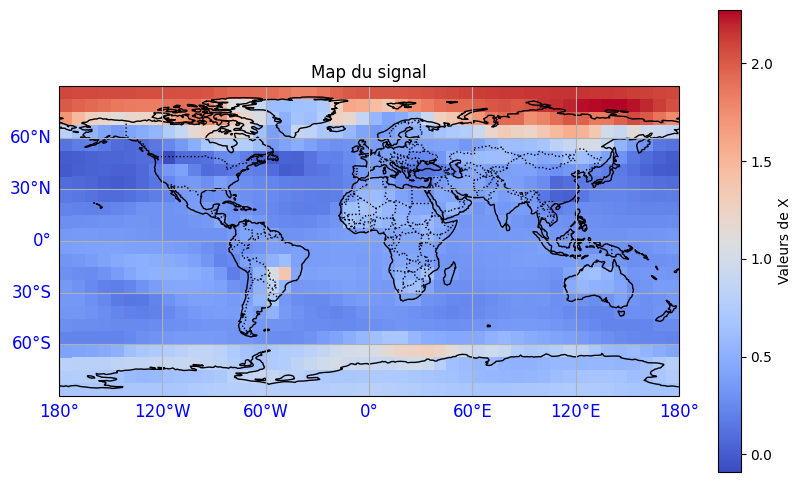

In [ ]:
plot_map(X_map, latitudes, longitudes, title='Map du signal', var_name='X')

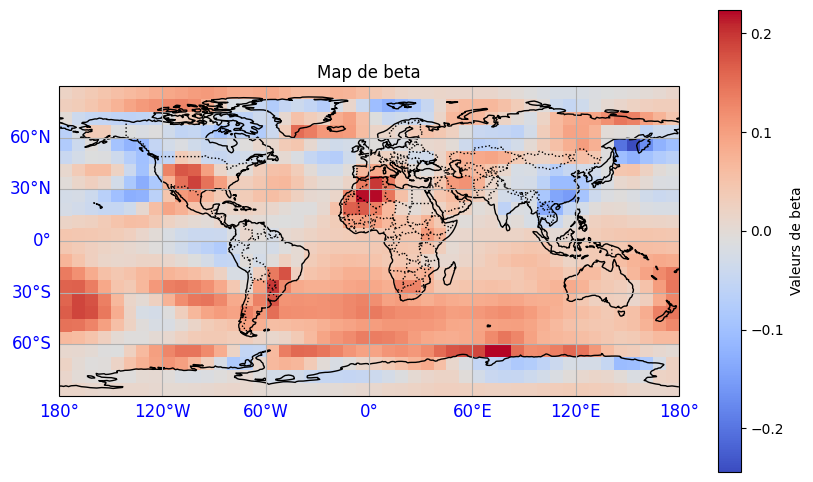

In [ ]:
plot_map(beta_map, latitudes, longitudes)

Sur la carte du signal, on observe particulièrement un changement climatique sur au pôle Sud. On observe aussi aucun signal négatif, il peut y avoir des endroits avec un signal faible mais jamais négatif ce qui indique que le réchauffement climatique s’observe partout dans le monde mais à des intensités différentes.


La carte de $\beta$ représente une balance entre les endroits ou le signal est fort et ou le bruit est faible. Les regions où l'on va pourvoir observer le plus surement un changement climatique sont l'Afrique de Nord, l'Amérique du Sud (au niveau de l'Uruguay) et aussi au milieu de l'océan Pacifique.


##Libération de la mémoire

In [ ]:
# Libérer la mémoire
del past_reshaped  # Supprimer une variable non utilisée
del present_reshaped
del full_data_past
del full_data_present
del data_past
del data_present
del anomalies_past
del anomalies_present
del seasonalities
del xarray

gc.collect()  # Forcer la collecte de mémoire

10183

# Test Statistique

Désormais, on va pouvoir calculer la statistique de test $Z(t) = \frac{(Y_\text{obs}(t) \beta}{\gamma}$ avec $\gamma^2 = X^T C_N^{-1} X$.

Nous allons rejeter l'hypothèse nulle qu'il n'y a pas de changement climatique si le scalaire $Z(t) > 1,96$ ce qui est équivalent à un test statistique de niveau 5%

## Calcul de Gamma

In [ ]:
def calculate_gamma(C_N, X):
    inv_C_N = np.linalg.inv(C_N)
    gamma = np.sqrt(np.abs(np.dot(np.dot(np.transpose(X), inv_C_N), X)))
    return gamma

gamma = calculate_gamma(C_N, X)
print(gamma)

4.365475978533663


## Calcul de la série temporelle $Z$

In [ ]:
def calculate_Z(ds, beta, gamma):
    Z = np.dot(ds, beta) / gamma
    return Z

##Test sur les simulations

Dans un premier temps, on va faire un calibrage de notre test pour tester la fiabilité de notre algorithme et détermier le nombre de composentes principales optimal pour avoir le test le plus précis possible.

Pour ce faire, on va séparer les fichiers. On va utiliser 1 fichier pour le test et les autres pour l'entrainement et le calcule de $\beta$.

Ensuite, on calcule la série temporelle du fichier test à l'aide du $\beta$ calculer et du $\gamma$ déterminer avec les fichiers d'entrainement.

Pour détermier la précision du test, on va évaluer l'erreur de première espèce qui doit être vers 5% ainsi que la puissance du test qui doit se rapprocher le plus possible de 1.

Après on va faire ça sur tous les fichiers, et faire varier le nombre de composentes principales.

### Extraction et traitement des données de simulations

Création deux tableaux (past et present) où chaque case représente un fichier (pour éviter de devoir les ouvrir à chaque fois et d'extraire les données, ce qui prend le plus de temps)

In [ ]:
def tab_past_present(path, start_past, end_past, start_present, end_present, n_f):
    if(n_f == 0 or n_f > 50):
        n = 50
    else:
        n = n_f
    tab_past = []
    tab_present = []
    for file_name in os.listdir(path)[:n]:
        full_path = path + '/' + file_name
        xarray = xr.open_dataset(full_path)
        past, present = traitement_data(xarray, start_past, end_past, start_present, end_present, 1000)
        time, lat, lon = past.shape
        past_reshaped = past.reshape((time, lat * lon))
        time, lat, lon = present.shape
        present_reshaped = present.reshape((time, lat * lon))
        tab_past.append(past_reshaped)
        tab_present.append(present_reshaped)
    return tab_past, tab_present

In [ ]:
def data_tab_to_pca(tab_past, tab_present, n_comp):
    pca = PCA(n_components=int(n_comp))
    copy_past = tab_past.copy()
    copy_present = tab_present.copy()
    copy_past[0] = pca.fit_transform(tab_past[0])
    for i in range(len(tab_past)):
        copy_past[i] = pca.transform(tab_past[i])
        copy_present[i] = pca.transform(tab_present[i])
    return copy_past, copy_present

Calcul de l'erreur de première espèce et de la puissance du test pour les 50 fichiers (en prenant tour à tour un fichier pour le test et le reste pour l'entrainement)

In [ ]:
def calc_type_I_power(tab_past, tab_present, ncp, alpha):
    s = stats.norm.ppf(1 - alpha)
    list_err_I, list_power = [], []
    for i in range(len(tab_past)):
        train_past, train_present = [], []
        for j in range(len(tab_past)):
            if(i != j):
                train_past.append(tab_past[j])
                train_present.append(tab_present[j])

        train_past = np.array(train_past)
        train_present = np.array(train_present)

        n_simulation, time, lat_lon = train_past.shape
        train_past = train_past.reshape((n_simulation*time, lat_lon))
        n_simulation, time, lat_lon = train_present.shape
        train_present = train_present.reshape((n_simulation*time, lat_lon))

        C_N, X = compute_covariance_and_signal(train_past, train_present)
        beta = calculate_beta(C_N, X)
        gamma = calculate_gamma(C_N, X)

        Z_test_present = calculate_Z(train_present, beta, gamma)
        Z_test_past = calculate_Z(train_past, beta, gamma)

        err_I = np.mean(Z_test_past > s)
        power = np.mean(Z_test_present > s)
        list_err_I.append(err_I)
        list_power.append(power)

    return np.mean(list_err_I), np.mean(list_power)

### Calibrage de test

Création du tableau

In [ ]:
tab_past, tab_present = tab_past_present(path, start_past, end_past, start_present, end_present, 50)

Calcul de l'erreur de première espèce et de la puissance du test

In [ ]:
list_mean_err_I, list_mean_power = [], []
alpha = 0.05
nb_comp = np.arange(10, 71, 5)

for n in nb_comp:
    print(f"Pour n = {n}")

    tab_past_pca, tab_present_pca = data_tab_to_pca(tab_past, tab_present, n)

    err_I, power = calc_type_I_power(tab_past_pca, tab_present_pca, n, alpha)
    list_mean_err_I.append(err_I)
    list_mean_power.append(power)

Pour n = 10
Pour n = 15
Pour n = 20
Pour n = 25
Pour n = 30
Pour n = 35
Pour n = 40
Pour n = 45
Pour n = 50
Pour n = 55
Pour n = 60
Pour n = 65
Pour n = 70


Traçons maintenant l'erreur de première espèce et la puissance du test en fonction de n (le nombre de composantes principales)

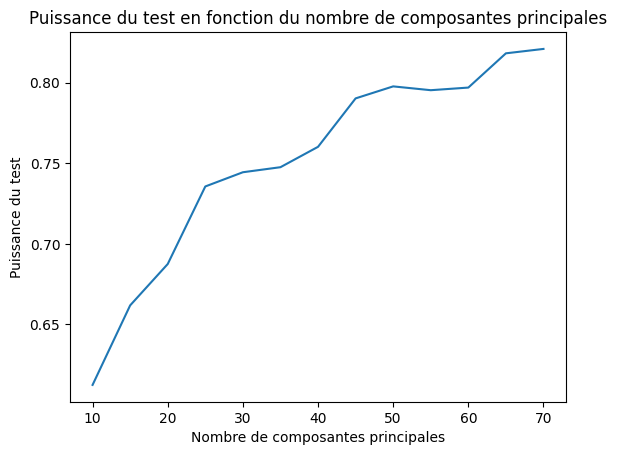

In [ ]:
plt.plot(nb_comp, list_mean_power)
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Puissance du test')
plt.title('Puissance du test en fonction du nombre de composantes principales')
plt.show()

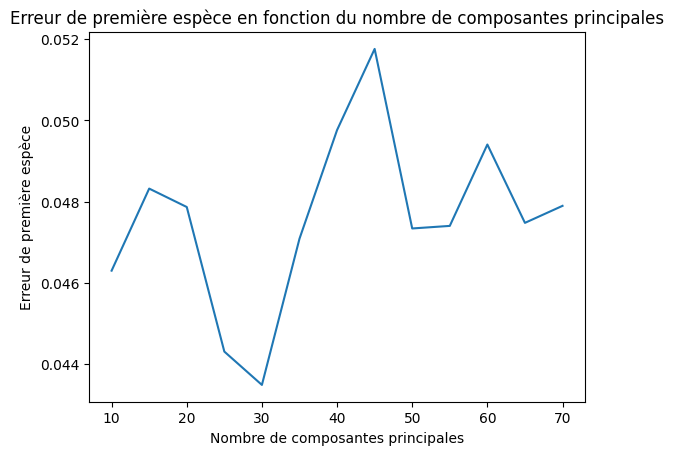

In [ ]:
plt.plot(nb_comp, list_mean_err_I)
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Erreur de première espèce')
plt.title('Erreur de première espèce en fonction du nombre de composantes principales')
plt.show()

On observe tatata

On obtient un calibrage optimal du test pour un n_component =

In [ ]:
ncp_opt = 70

On calcul donc beta avec pour cette valeure

In [ ]:
C_N, X, beta, past, present = beta_calculation(path, start_past, end_past, start_present, end_present, ncp_opt, nb_pts, nb_fichiers)

### Libération de la mémoire

## Test sur des observations

### Extraction et traitement de données observées

In [ ]:
# file_name = "Copie de ERA5_1940-2024_Monthly_TAS.nc"
obs = xr.open_dataset(path_obs + '/' + file_name)
print(f"Processing file: {file_name}")

Processing file: Copie de ERA5_1940-2024_Monthly_TAS.nc


### Traitement des données

Mettre les dates sous le bon format

In [ ]:
obs['date'] = pd.to_datetime(obs['date'], format='%Y%m%d') # convertion de la date

On réduit la granularité des observation, pour vaoir la meme dimension que $\beta$

In [ ]:
def reduce_granularity_obs(ds, target_shape=(72, 144)):
    ds_reduced = ds.coarsen(latitude=ds.sizes['latitude'] // target_shape[0],
                            longitude=ds.sizes['longitude'] // target_shape[1],
                            boundary='trim').mean()
    return ds_reduced

obs = reduce_granularity_obs(obs)

On calcul le saisonalité

In [ ]:
print(obs['date'].isel(date=50))

<xarray.DataArray 'date' ()> Size: 8B
array('1944-03-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    number   int64 8B 0
    date     datetime64[ns] 8B 1944-03-01
    expver   <U4 16B '0001'


In [ ]:
data_past = obs.isel(date=slice(0, 50)) # on choisit les 50 premières dates pour représenter le passé

seasonalities = data_past.groupby('date.month').mean("date")

anomalies_obs = obs.groupby('date.month') - seasonalities
anomalies_obs = anomalies_obs.resample(date='1YE').mean()

On réduit la dimension

In [ ]:
date, longitude, latitude = anomalies_obs.sizes['date'], anomalies_obs.sizes['longitude'], anomalies_obs.sizes['latitude']
anomalies_obs = np.array(anomalies_obs.to_dataarray())
anomalies_obs = anomalies_obs.reshape(date, longitude * latitude)
print(anomalies_obs.shape)

(85, 10368)


On réduit en composents principaux

In [ ]:
pca = PCA(n_components=70)
obs_pca = pca.fit_transform(anomalies_obs)
obs_pca.shape

(85, 70)

### Test

On calcul la série temporel

In [ ]:
Z_obs = calculate_Z(obs_pca, beta, gamma)
Z_obs.shape

(85,)

In [ ]:
alpha = 0.05
s = stats.norm.ppf(1 - alpha)

On trace la série temporel

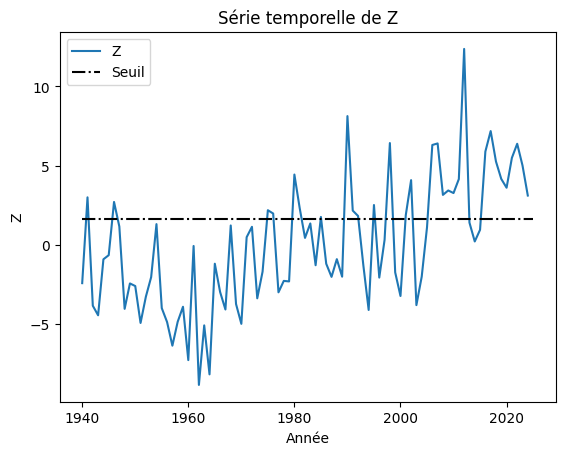

In [ ]:
val = np.arange(1940, 1940 + 85, 1)
plt.plot(val, Z_obs, label='Z')
plt.hlines(y=s, xmin=1940, xmax=1940 + len(Z_obs), color='black', linestyles='-.', label='Seuil')
plt.xlabel('Année')
plt.ylabel('Z')
plt.title('Série temporelle de Z')
plt.legend()
plt.show()

On observe que de 1940 à 1980, on conserve H0, il n’y a pas de changement climatique même si sur certaines années on commence à observer un léger début de changement dans les températures.

Ensuite, des années 1990 à 2010, il y a de plus en plus d’années où la statistique observée dépasse le seuil, environ une année sur deux.

Enfin, de 2010 à nos jours, tous les ans on rejette H0 et on peut affirmer avec plus de 95% de chance, qu’il y a un changement climatique dû aux activités humaines. De plus, sur cette période, on aurait pu choisir un niveau beaucoup plus faible pour notre test statistique comme 0.1% que l’on aurait tout de même rejeté H0 et pu affirmé qu’il y a un changement climatique car le nouveau seuil serait de 3.3 alors que notre statistique observée est supérieur à 3.5.


# Conclusion

Pour conclure, grâce à la méthode de l’optimal fingerprint, nous avons réussi à montrer qu’il y avait un réchauffement climatique dû aux activités humaines et que notre niveau de confiance dans ce résultat est très élevé.